In [2]:
import torch
import torchvision.transforms as transforms               # include image preprocess tools
from torchvision.datasets import CIFAR10        # for loading images from Pytorch CIFAR
from torch.utils.data import DataLoader
import detectors
import timm


# check GPU status
print("Is CUDA available:", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

# load pre-trained model InceptionV3 and set mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# load fine-tuned model
model = timm.create_model("resnet18_cifar10", pretrained=True)
model = model.to(device)
model.eval()

data_transform = transforms.Compose([
    transforms.ToTensor(),          # transfer to tensor
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])  # normalize
])

# load data set for training
pre_train_dataset = CIFAR10(root="../../data", train=True, download=True,transform=data_transform)
pre_test_dataset = CIFAR10(root="../../data", train=True, download=True, transform=data_transform)

train_loader = DataLoader(pre_train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(pre_test_dataset, batch_size=32, shuffle=False)

Is CUDA available: True
Device count: 1
Device name: NVIDIA GeForce RTX 3060 Ti
Files already downloaded and verified
Files already downloaded and verified


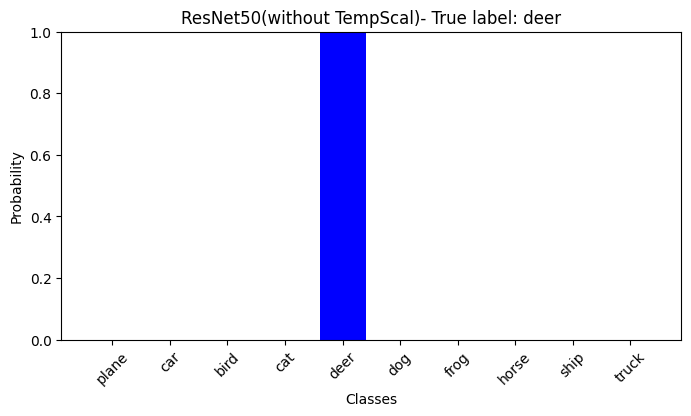

In [3]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

test_iter = iter(test_loader)
image, label = next(test_iter)
image, label = image[10].to(device), label[10].item()
model.eval()

with torch.no_grad():
    logits = model(image.unsqueeze(0))  
    probabilities = F.softmax(logits, dim=1).cpu().numpy().flatten() 

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(8, 4))
plt.bar(classes, probabilities, color='blue')
plt.xlabel("Classes")
plt.ylabel("Probability")
plt.title(f"ResNet50(without TempScal)- True label: {classes[label]}")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()

Before temperature - NLL: 0.001, ECE: 0.001
Optimal temperature: 4.895
After temperature - NLL: 0.599, ECE: 0.445


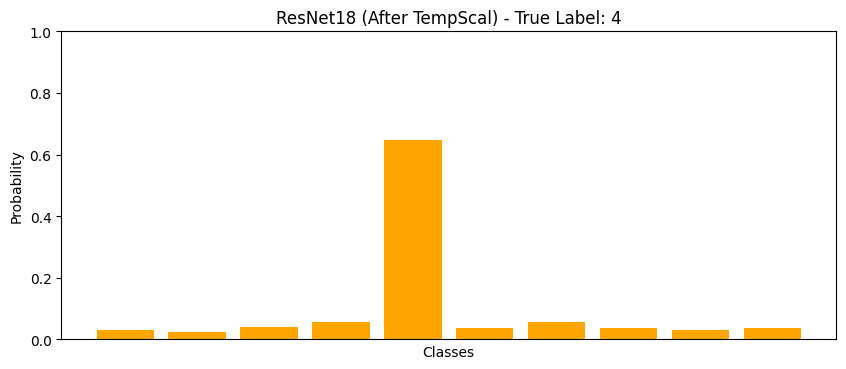

In [4]:
from src.temperature_scaling import ModelWithTemperature

model_with_temp = ModelWithTemperature(model, temperature = 5.0).to(device)
model_with_temp.set_temperature(train_loader)

model_with_temp.eval()
with torch.no_grad():
    logits = model_with_temp(image.unsqueeze(0)) 
    probabilities_temp = F.softmax(logits, dim=1).cpu().numpy().flatten() 

plt.figure(figsize=(10, 4))
plt.bar(classes, probabilities_temp, color='orange')
plt.xlabel("Classes")
plt.ylabel("Probability")
plt.title(f"ResNet18 (After TempScal) - True Label: {label}")
plt.ylim(0, 1)
plt.xticks([]) 
plt.show()